# Introduction

Hello there! In this notebook the advantages of Binary Neural Networks are explored and compared to networks utilizing full precision calculations.

## Imports

First we need to import some packages to be ready to go...

In [1]:
%matplotlib notebook
import sys
import torch
from torch import nn
import matplotlib.animation
import matplotlib.pyplot as plt
from torchvision.datasets import mnist
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

sys.path.append("../../")
from bitorch.layers import QLinear, QActivation, QConv2d, Debug_Input_Layer

print("everything imported!")


everything imported!


We want to train on the MNIST dataset, containing a collection of handwritten digits. For this we first download the dataset and then create loaders for training and testing:

In [2]:
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

Now we want to build a Model. At first we will create a full precision LeNet version. Bitorch comes with an included Debug_Input_Layer to output input tensors. Below the implementation of the model:

In [3]:
num_convolution_features = 64
num_linear_nodes = 1000
num_output_nodes = 10

# create images to capture the debug layers graphical output
# (this is a bit hacky but we want to prevent that the figure is printed below this cell, so...)
images = [0] * 10
fig = [1]

model = nn.Sequential(
    # first convolution block
    nn.Conv2d(1, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    # second convolution blocks
    nn.Conv2d(num_convolution_features, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    Debug_Input_Layer(graphic_debug=True, images=images, figure=fig, print_debug=False),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(num_convolution_features * 4 * 4, num_output_nodes),
    nn.BatchNorm1d(num_output_nodes),
    nn.Tanh(),

    nn.Linear(num_output_nodes, num_output_nodes),
)

You may notice that LeNet consists of two convolution blocks containing a convolution and a batchnorm layer, an tanh activation function and a max pool layer, followed by one blocks with linear units to classify the features retrieved from the prior layers.

We want to catch the weights of the second convolution block, so we place it right underneath it and pass some variables that will later be filled with matplotlib objects (yes, thats a bit hacky :P)

Now lets train our model:

<IPython.core.display.Javascript object>


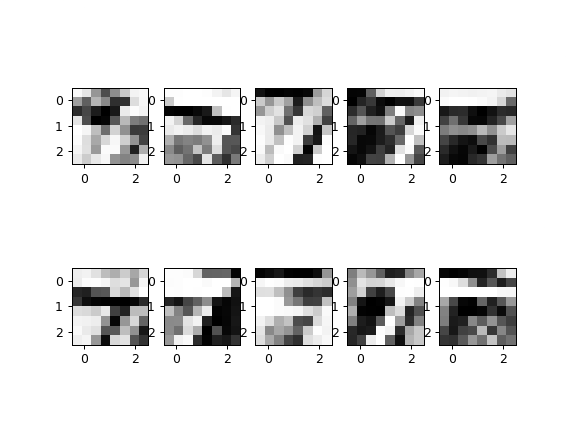

<IPython.core.display.Javascript object>


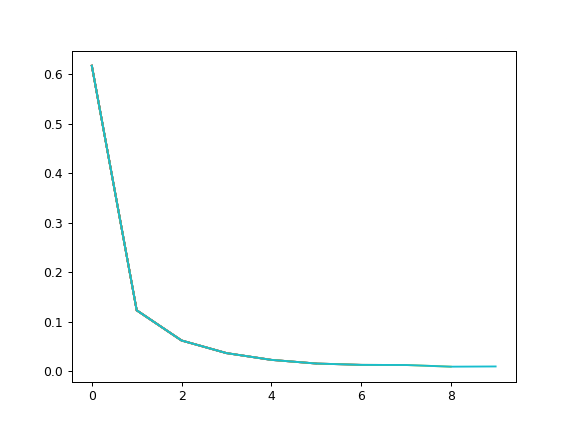

    Loss in epoch 1 for batch 100: 1.401419892311096
    Loss in epoch 1 for batch 200: 1.1350111269950867
    Loss in epoch 1 for batch 300: 0.9421374269326528
    Loss in epoch 1 for batch 400: 0.8027623915672302
    Loss in epoch 1 for batch 500: 0.6996247697472572
total loss of epoch 1 : 0.6176340598861376
    Loss in epoch 2 for batch 100: 0.1806024158746004
    Loss in epoch 2 for batch 200: 0.16294541798532008
    Loss in epoch 2 for batch 300: 0.1491608922680219
    Loss in epoch 2 for batch 400: 0.13969461323693394
    Loss in epoch 2 for batch 500: 0.13198803408443927
total loss of epoch 2 : 0.12321671621873975
    Loss in epoch 3 for batch 100: 0.07972693305462598
    Loss in epoch 3 for batch 200: 0.07335574494674801
    Loss in epoch 3 for batch 300: 0.07008271152774492
    Loss in epoch 3 for batch 400: 0.0675947884703055
    Loss in epoch 3 for batch 500: 0.06552267233282327
total loss of epoch 3 : 0.0621378483157605
    Loss in epoch 4 for batch 100: 0.04626900378614664

In [4]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)
num_epochs = 10

# this part is also for graphic output (still a bit hacky)
fig[0] = plt.figure()
axes = [plt.subplot(2, 5, i) for i in range(1, 11)]
example_img = torch.zeros((3, 3))
example_img[0][0] = 1.0
for idx, ax in enumerate(axes):
    images[idx] = ax.imshow(example_img, cmap='gray')

# we also want the loss to be plotted in a graph
fig2, ax2 = plt.subplots()
loss_plot = None
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    model.train()
    for idx, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()

        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if idx % 100 == 0 and idx > 0:
            print(f"    Loss in epoch {epoch + 1} for batch {idx}: {epoch_loss / idx}")
    epoch_loss /= len(train_loader)
    
    losses.append(epoch_loss)
    loss_plot = ax2.plot(losses)
    fig2.canvas.draw()
    print("total loss of epoch", epoch+1, ":", epoch_loss)

You can see as the loss declines the full precision feature maps vary a bit in shade.

Below we evaluate how well our full precision network performs on a test dataset by calculating its accuarcy when confronted with previously unseen examples:

In [5]:
model.eval()
test_loss = 0.0
correct = 0.0
# now validate model with test dataset
with torch.no_grad():
    for x_test, y_test in test_loader:

        y_hat = model(x_test)
        test_loss += criterion(y_hat, y_test).item()

        # determine count of correctly predicted labels
        predictions = torch.argmax(y_hat, dim=1)
        correct += torch.sum(y_test == predictions).item()
test_loss /= len(test_loader)
accuracy = correct / (len(test_loader) * test_loader.batch_size)
print("test loss:", test_loss, "test accuracy:", accuracy)

test loss: 0.03883191349101253 test accuracy: 0.9868


Next, we want to evaluate the performance of our binary layers by first building a model:

In [6]:
num_convolution_features = 64
num_linear_nodes = 1000
num_output_nodes = 10

# create images to capture the debug layers graphical output
# (this is a bit hacky but we want to prevent that the figure is printed below this cell, so...)
images = [0] * 10
fig = [1]

model = nn.Sequential(
    # first convolution block
    nn.Conv2d(1, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    # second convolution blocks
    QConv2d(num_convolution_features, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    QActivation(),
    Debug_Input_Layer(graphic_debug=True, images=images, figure=fig, print_debug=False),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    QLinear(num_convolution_features * 4 * 4, num_linear_nodes),
    nn.BatchNorm1d(num_linear_nodes),
    QActivation(),

    QLinear(num_linear_nodes, 10),
)

In the quantized LeNet version above we simply exchanged the convolution, linear and activation layers starting from the second convolution block with our corresponding quantized versions.

Now we train this model using the exact same code as before:

<IPython.core.display.Javascript object>


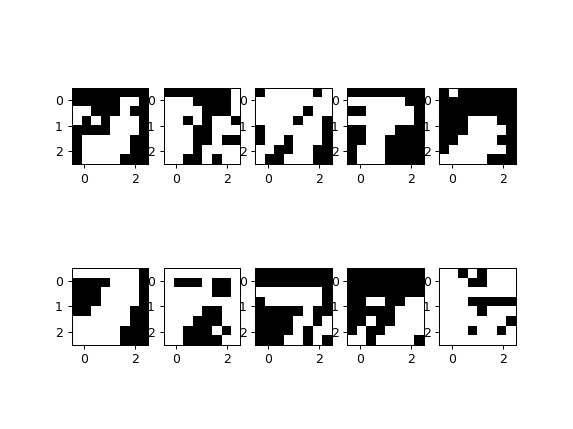

<IPython.core.display.Javascript object>


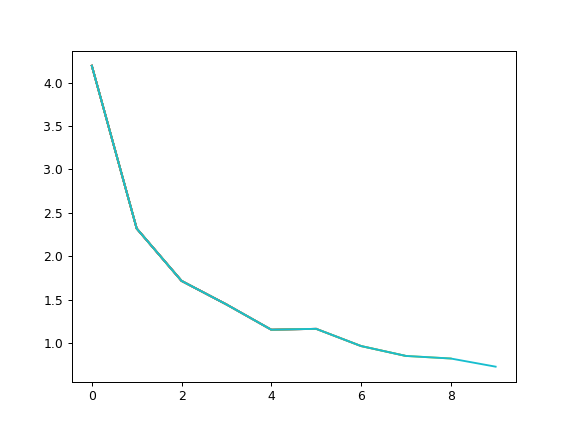

    Loss in epoch 1 for batch 100: 7.995758032798767
    Loss in epoch 1 for batch 200: 6.451079058945179
    Loss in epoch 1 for batch 300: 5.4574893683044685
    Loss in epoch 1 for batch 400: 4.866140387643022
    Loss in epoch 1 for batch 500: 4.47269333378068
total loss of epoch 1 : 4.195011738910475
    Loss in epoch 2 for batch 100: 2.642959499744293
    Loss in epoch 2 for batch 200: 2.7184158710453494
    Loss in epoch 2 for batch 300: 2.6908499708413958
    Loss in epoch 2 for batch 400: 2.5077962671857237
    Loss in epoch 2 for batch 500: 2.4123837712153584
total loss of epoch 2 : 2.3187354757416667
    Loss in epoch 3 for batch 100: 1.9012263423220799
    Loss in epoch 3 for batch 200: 1.730857134133981
    Loss in epoch 3 for batch 300: 1.7045249881730853
    Loss in epoch 3 for batch 400: 1.7615216752142415
    Loss in epoch 3 for batch 500: 1.7491664804251192
total loss of epoch 3 : 1.7149227430812142
    Loss in epoch 4 for batch 100: 1.7152971451792844
    Loss in epo

In [7]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)
num_epochs = 10

# this part is also for graphic output (still a bit hacky)
fig[0] = plt.figure()
axes = [plt.subplot(2, 5, i) for i in range(1, 11)]
example_img = torch.zeros((3, 3))
example_img[0][0] = 1.0
for idx, ax in enumerate(axes):
    images[idx] = ax.imshow(example_img, cmap='gray')

# we also want the loss to be plotted in a graph
fig2, ax2 = plt.subplots()
loss_plot = None
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    model.train()
    for idx, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()

        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if idx % 100 == 0 and idx > 0:
            print(f"    Loss in epoch {epoch + 1} for batch {idx}: {epoch_loss / idx}")
    epoch_loss /= len(train_loader)
    
    losses.append(epoch_loss)
    loss_plot = ax2.plot(losses)
    fig2.canvas.draw()
    print("total loss of epoch", epoch+1, ":", epoch_loss)

And now we also evaluate the performance of our quantized model:

In [8]:
model.eval()
test_loss = 0.0
correct = 0.0
# now validate model with test dataset
with torch.no_grad():
    for x_test, y_test in test_loader:

        y_hat = model(x_test)
        test_loss += criterion(y_hat, y_test).item()

        # determine count of correctly predicted labels
        predictions = torch.argmax(y_hat, dim=1)
        correct += torch.sum(y_test == predictions).item()
test_loss /= len(test_loader)
accuracy = correct / (len(test_loader) * test_loader.batch_size)
print("test loss:", test_loss, "test accuracy:", accuracy)

test loss: 0.9133082878866077 test accuracy: 0.9827
